In [1]:
# !pip install -q -U "tensorflow-text==2.8.*"

In [2]:
# !pip install -q tf-models-official==2.7.0

In [3]:
# !pip install -q pydot

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# train_df = pd.read_csv('../data/processed/train_data_processed.csv', index_col='id')
train_df = pd.read_csv('../data/processed/train_data_processed.csv', index_col='id')
train_df = train_df[train_df['language'] == 'English'].reset_index(drop=True)
train_df.head()

,title,genre,description,year,language,processed_description_string
0,Oscar et la dame rose,drama,Listening in to a conversation between his do...,2009,English,listen convers doctor parent 10-year-old oscar...
1,Cupid,thriller,A brother and sister with a past incestuous r...,1997,English,brother sister past incestu relationship curre...
2,"Young, Wild and Wonderful",adult,As the bus empties the students for their fie...,1980,English,bu empti student field trip museum natur histo...
3,The Secret Sin,drama,To help their unemployed father make ends mee...,1915,English,help unemploy father make end meet edith twin ...
4,The Unrecovered,drama,The film's title refers not only to the un-re...,2007,English,film titl refer un-recov bodi ground zero also...


In [7]:
train_df = train_df.drop(columns=['Unnamed: 0'])

In [8]:
# def truncate_and_split_descriptions(df, batch_size=128):
#     new_df_dict = {'genre':[], 'processed_description_string': []}
#     for _, row in df.iterrows():
#         processed_description = row['processed_description_string'].split()
#         genre = row['genre']
#         n = len(processed_description)
#         for i in range(0, n, batch_size):
#             new_df_dict['genre'].append(genre)
#             new_df_dict['processed_description_string'].append(' '.join(processed_description[i:min(n, i+batch_size)]))
#     new_df = pd.DataFrame(new_df_dict)
#     return new_df    

In [9]:
# train_df = truncate_and_split_descriptions(train_df)

In [10]:
unique_genres = train_df['genre'].unique()
genre_encoding = dict([(unique_genres[i], i) for i in range(unique_genres.shape[0])])
train_df['genre'] = train_df['genre'].map(genre_encoding)
train_df = train_df.sample(frac=1, random_state=42)
train_df

,title,genre,description,year,processed_description,processed_description_string,language
29172,Bash maystorat na ekskurziya,2,Bash mastorat went on an organized trip to Hu...,1980,"['bash', 'mastorat', 'went', 'organ', 'trip', ...",bash mastorat went organ trip hungari budapest...,English
11373,Car Stars,2,A mockumentary about auto shows centering aro...,2011,"['mockumentari', 'auto', 'show', 'center', 'ar...",mockumentari auto show center around johnathon...,English
9517,Dr. Rameau,0,"Pierre Rameau, the son of a poor gate-keeper,...",1915,"['pierr', 'rameau', 'son', 'poor', 'gate-keep'...",pierr rameau son poor gate-keep becom foremost...,English
11489,Seeds,1,SEEDS features ten teenagers who undertake th...,2004,"['seed', 'featur', 'ten', 'teenag', 'undertak'...",seed featur ten teenag undertak challeng coexi...,English
26000,"""Angels in Paradise""",0,Blake Vaas controls an empire throughout Los ...,2014,"['blake', 'vaa', 'control', 'empir', 'througho...",blake vaa control empir throughout lo angel in...,English
...,...,...,...,...,...,...,...
16850,Nae kkangpae gateun aein,2,(Korean with English subtitles) An unlikely r...,2010,"['korean', 'english', 'subtitl', 'unlik', 'rom...",korean english subtitl unlik romanc brew dong-...,English
6265,Ashchorjyo Prodeep,0,"The story of a modern day Aladdin, set agains...",2013,"['stori', 'modern', 'day', 'aladdin', 'set', '...",stori modern day aladdin set backdrop contempo...,English
11284,That is the year,1,That is the year is a 12 minute documentary a...,2017,"['year', '12', 'minut', 'documentari', 'footba...",year 12 minut documentari footbal fan ankara k...,English
860,Svindleren,1,Richard Ringheim is a young celebrity crimina...,2005,"['richard', 'ringheim', 'young', 'celebr', 'cr...",richard ringheim young celebr crimin whose ini...,English


In [11]:
num_labels = train_df['genre'].nunique()
num_labels

3

In [12]:
x = train_df['processed_description_string'].values
y = pd.get_dummies(train_df['genre']).values

In [13]:
num_examples = train_df.shape[0]

train_set_size = int(num_examples * 0.9)
val_set_size = int(num_examples * 0.05)
test_set_size = num_examples - train_set_size - val_set_size

x_train = x[:train_set_size]
x_val = x[train_set_size:train_set_size+val_set_size]
x_test = x[train_set_size+val_set_size:train_set_size+val_set_size+test_set_size]

y_train = y[:train_set_size]
y_val = y[train_set_size:train_set_size+val_set_size]
y_test = y[train_set_size+val_set_size:train_set_size+val_set_size+test_set_size]

In [14]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [15]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

2022-11-29 16:58:43.020933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 16:58:43.032647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 16:58:43.032798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 16:58:43.033229: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [17]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(128)(net)
    net = tf.keras.layers.Dropout(0.05)(net)
    net = tf.keras.layers.Dense(512)(net)
    net = tf.keras.layers.Dropout(0.05)(net)
    net = tf.keras.layers.Dense(128)(net)
    net = tf.keras.layers.Dropout(0.05)(net)
    net = tf.keras.layers.Dense(128)(net)
    net = tf.keras.layers.Dense(num_labels, activation='softmax')(net)
    return tf.keras.Model(text_input, net)

In [18]:
classifier_model = build_classifier_model()

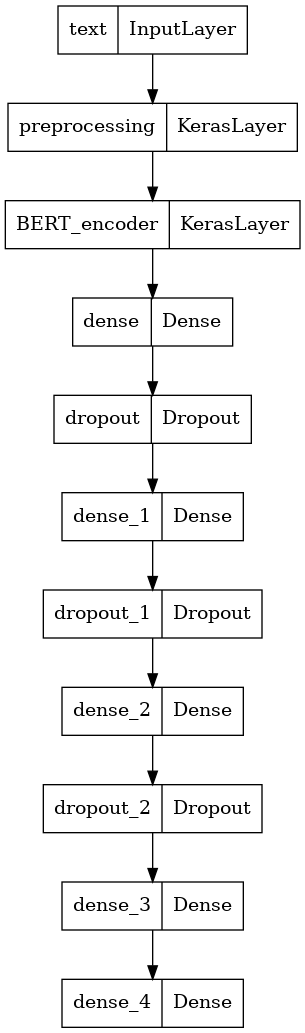

In [19]:
tf.keras.utils.plot_model(classifier_model, to_file='../models/{}.png'.format(bert_model_name))

In [20]:
epochs = 10

In [21]:
classifier_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [22]:
print(f'Training model with {tfhub_handle_encoder}')

my_callbacks  = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
history = classifier_model.fit(x_train, y_train,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=my_callbacks,
                    verbose=1
                   )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/10
953/953 [==============================] - 34s 33ms/step - loss: 0.6618 - accuracy: 0.7157 - val_loss: 0.5937 - val_accuracy: 0.7435
Epoch 2/10
953/953 [==============================] - 32s 33ms/step - loss: 0.4497 - accuracy: 0.8269 - val_loss: 0.6346 - val_accuracy: 0.7648


In [23]:
loss, accuracy = classifier_model.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

53/53 [==============================] - 1s 26ms/step - loss: 0.6335 - accuracy: 0.7655
Loss: 0.6335001587867737
Accuracy: 0.7655050158500671


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


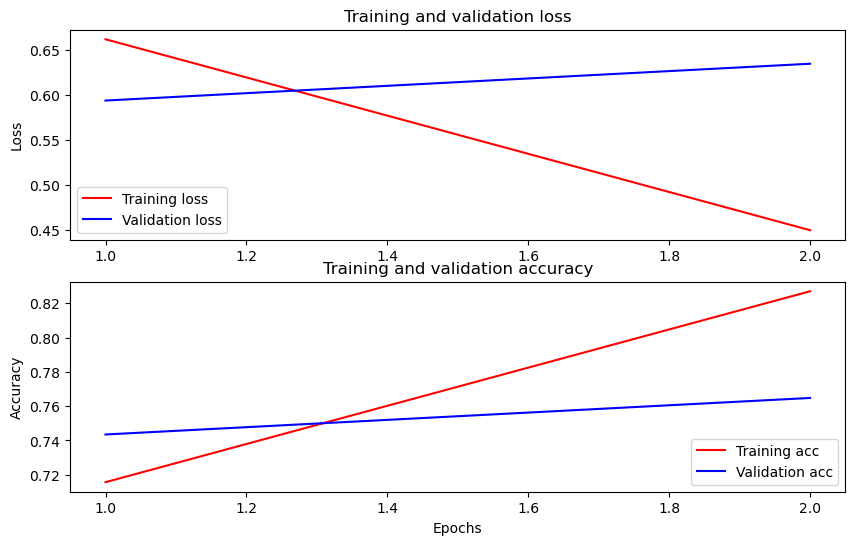

In [24]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [25]:
saved_model_path = '../models/{}'.format(bert_model_name)

classifier_model.save(saved_model_path, include_optimizer=False)

2022-11-29 16:59:57.568883: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [26]:
x_custom = np.array(['a hilarious tale'.lower()])

In [27]:
classifier_model.predict(x_custom)[0].argmax()

0

In [28]:
genre_encoding

{'drama': 0, 'documentary': 1, 'comedy': 2}

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


def get_confusion_matrix(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
    plt.show()

    return None


def get_f1_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    return f1

In [30]:
y_pred = classifier_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

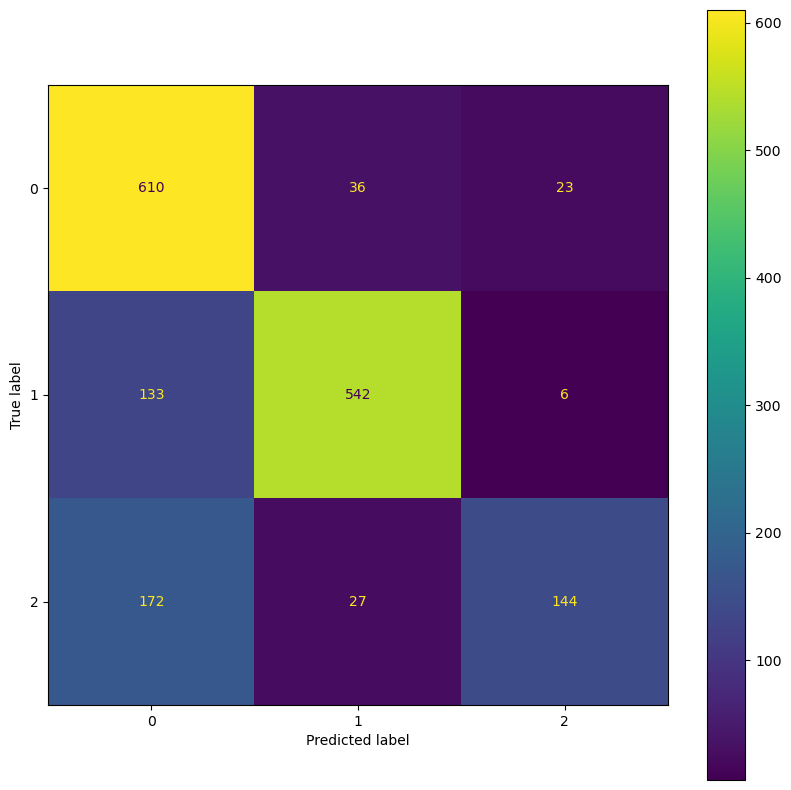

In [31]:
get_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

In [32]:
get_f1_score(np.argmax(y_test, axis=1), y_pred)

0.7564903226103571